In [1]:
import pdb
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import itemfreq
from collections import Counter
from IPython.display import display

import saxpy
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data

In [2]:
def getData(filename, verbose=0):
    df             = pd.read_csv(filename)
    df.columns     = df.columns.str.strip()
    df['DATETIME'] = pd.to_datetime(df['DATETIME'], format='%d/%m/%y %H')
    df.set_index('DATETIME', inplace=True)
    
    
    if verbose:
        print (' -------------------------------------------------------------------------------------- ')
        print (' - Total Len : ', len(df))
        print (' - Label     : ', df['ATT_FLAG'].value_counts())
        print (' - Columns   : ', df.columns, ' || Total : ', len(df.columns))
        print (' - Dates     : ', df.index[0], ' -- ', df.index[-1])
        # print (df.head())
    return df
    

if __name__ == "__main__":
    df_train = getData('data/BATADAL_dataset03.csv', verbose=1)
    df_val   = getData('data/BATADAL_dataset04.csv', verbose=1)

 -------------------------------------------------------------------------------------- 
 - Total Len :  8761
 - Label     :  0    8761
Name: ATT_FLAG, dtype: int64
 - Columns   :  Index(['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1',
       'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5',
       'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9',
       'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2',
       'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302',
       'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422', 'ATT_FLAG'],
      dtype='object')  || Total :  44
 - Dates     :  2014-01-06 00:00:00  --  2015-01-06 00:00:00
 -------------------------------------------------------------------------------------- 
 - Total Len :  4177
 - Label     :  -999    3958
 1       219
Name: ATT_FLAG, dtype: int64
 - Columns   :  Index(['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1',
   

# Task - Discretization
 - Discretize the sensor data using any of the methods discussed in class
   - Explain and show how it makes sense
   - Vizualize the discretization
 - Apply any of the sequential data mining methods
   - What kind of anomalies can you detect using the sequential model? 
   - Which sensors can be modeled effectively? 

# Task3- Discretization + Mining

In [3]:
if (1):
    def doNorm(data):
        return (data - data.mean(axis = 0)) / data.std(axis = 0)

    def doPAA(data, param_PAALen): # Piecewise Aggregate Approximation (reduce the dimensionality)
        data_split_count = len(data)//param_PAALen 
        data_split = np.array_split(data, data_split_count)
        
        data_paa = []
        data_idx  = [] 
        for i,item in enumerate(data_split):
            # if i < 4 : print (item, item.mean())
            data_paa.append(item.mean())
            if (i == 0):
                data_idx.append(0)
            else:
                data_idx.append(data_idx[i-1] + len(item))
            
        return data_paa, data_idx

    def doStringify99(data, alphabet):
        alphabet_len = len(alphabet)
        data_res     = list(data)
        # https://github.com/seninp/saxpy/blob/master/saxpy/alphabet.py
        thresh     = norm.ppf(np.linspace(1./alphabet_len,1-1./alphabet_len, alphabet_len-1))
        
        for idx, item_paa in enumerate(data_res):
            tmp = min(enumerate(thresh), key=lambda x: abs(x[1]-item_paa)) # (thresh_idx, thresh_item)
            if item_paa < tmp[1]: data_res[idx] = alphabet[tmp[0]]
            else                : data_res[idx] = alphabet[tmp[0]+1]
        return data_res
    
    def doStringify(data, alphabet):
        alphabet_len = len(alphabet)
        data_res     = list(data)
        
        # https://github.com/seninp/saxpy/blob/master/saxpy/alphabet.py
        thresh       = norm.ppf(np.linspace(1./alphabet_len,1-1./alphabet_len, alphabet_len-1))
        thresh       = np.hstack(([-np.inf], thresh))
                
        # https://github.com/seninp/saxpy/blob/master/saxpy/sax.py
        for i in range(0, len(data_res)):
            data_res_num = data_res[i]
            # if the number below 0, start from the bottom, or else from the top
            if(data_res_num >= 0):
                j = alphabet_len - 1
                while ((j > 0) and (thresh[j] >= data_res_num)):
                    j = j - 1
                data_res[i] = alphabet[j]
            else:
                j = 1
                while (j < alphabet_len and thresh[j] <= data_res_num):
                    j = j + 1
                data_res[i] = alphabet[j-1]
            # print (' - [DEBUG] data_res_num : ', round(data_res_num,2), ' || Thresh : ', thresh, ' || j : ', j)
            # pdb.set_trace()
        return data_res

    def doNGrams(data):
        trigrams = []
        for i in range(0,len(data)):
            if i < len(data)-2:
                trigram = data[i] + data[i+1] + data[i+2]
                # trigram = data[i:i+3]
                trigrams.append(trigram)
        return trigrams

else:
    from saxpy.znorm import znorm
    from saxpy.alphabet import cuts_for_asize
    from saxpy.paa import paa
    from saxpy.sax import ts_to_string

 - [DEBUG] For col -  L_T1  || Anomalies :  ['bbb', 'cbd']
 - [DEBUG] For col -  L_T2  || Anomalies :  ['bab', 'ddd']
 - [DEBUG] For col -  L_T3  || Anomalies :  []
 - [DEBUG] For col -  L_T4  || Anomalies :  ['ada', 'bda', 'bdd', 'daa', 'dad', 'dda']
 - [DEBUG] For col -  L_T5  || Anomalies :  []
 - [DEBUG] For col -  L_T6  || Anomalies :  ['aad', 'bac', 'caa', 'dba']
 - [DEBUG] For col -  L_T7  || Anomalies :  ['aad', 'bdd', 'cda', 'dab', 'dba', 'ddc']
 - [DEBUG] For col -  F_PU1  || Anomalies :  ['daa']
 - [DEBUG] For col -  S_PU1  || Anomalies :  []
 - [DEBUG] For col -  F_PU2  || Anomalies :  ['acd', 'cdc']
 - [DEBUG] For col -  S_PU2  || Anomalies :  []
 - [DEBUG] For col -  F_PU3  || Anomalies :  []
 - [DEBUG] For col -  S_PU3  || Anomalies :  []
 - [DEBUG] For col -  F_PU4  || Anomalies :  []
 - [DEBUG] For col -  S_PU4  || Anomalies :  []
 - [DEBUG] For col -  F_PU5  || Anomalies :  []
 - [DEBUG] For col -  S_PU5  || Anomalies :  []
 - [DEBUG] For col -  F_PU6  || Anomalies : 

/home/strider/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


 - [DEBUG] For col -  S_PU8  || Anomalies :  []
 - [DEBUG] For col -  F_PU9  || Anomalies :  []
 - [DEBUG] For col -  S_PU9  || Anomalies :  []
 - [DEBUG] For col -  F_PU10  || Anomalies :  ['aba', 'abb', 'bab']
 - [DEBUG] For col -  S_PU10  || Anomalies :  ['abb', 'bab']
 - [DEBUG] For col -  F_PU11  || Anomalies :  ['ddd']
 - [DEBUG] For col -  S_PU11  || Anomalies :  ['ddd']
 - [DEBUG] For col -  F_V2  || Anomalies :  ['abb', 'abd', 'bdc', 'dab']
 - [DEBUG] For col -  S_V2  || Anomalies :  ['abb']
 - [DEBUG] For col -  P_J280  || Anomalies :  ['aac', 'bcb', 'cac', 'ccd', 'dbc']
 - [DEBUG] For col -  P_J269  || Anomalies :  ['add']
 - [DEBUG] For col -  P_J300  || Anomalies :  ['cdc', 'dba']
 - [DEBUG] For col -  P_J256  || Anomalies :  []
 - [DEBUG] For col -  P_J289  || Anomalies :  ['cdc', 'dba']
 - [DEBUG] For col -  P_J415  || Anomalies :  ['cca']
 - [DEBUG] For col -  P_J302  || Anomalies :  ['aac', 'bdd', 'caa', 'cdd', 'dba', 'dca', 'dcd', 'dda', 'ddc', 'ddd']
 - [DEBUG] For c

,column,TN,FP,FN,TP,accuracy,precision,recall,f_score
0,L_T1,3898,60,219,0,93.320565,0.000000,0.000000,0.000000
1,L_T2,3898,60,219,0,93.320565,0.000000,0.000000,0.000000
2,L_T3,3958,0,219,0,94.757003,0.000000,0.000000,0.000000
3,L_T4,3844,114,183,36,92.889634,24.000000,16.438356,19.512195
4,L_T5,3958,0,219,0,94.757003,0.000000,0.000000,0.000000
5,L_T6,3828,130,219,0,91.644721,0.000000,0.000000,0.000000
6,L_T7,3738,220,219,0,89.490065,0.000000,0.000000,0.000000
7,F_PU1,3957,1,190,29,95.427340,96.666667,13.242009,23.293173
8,S_PU1,3958,0,219,0,94.757003,0.000000,0.000000,0.000000
9,F_PU2,3918,40,219,0,93.799378,0.000000,0.000000,0.000000


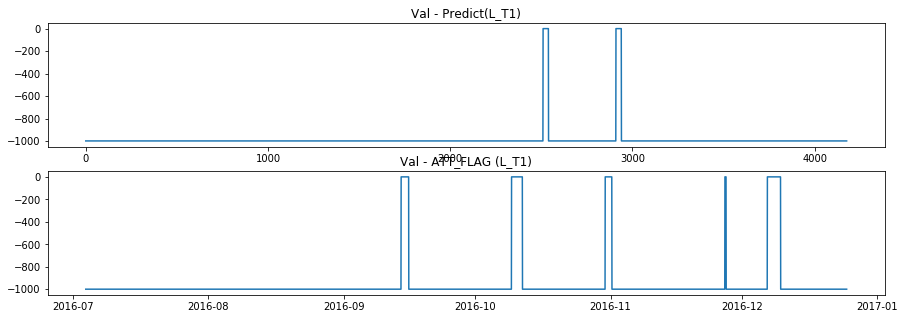

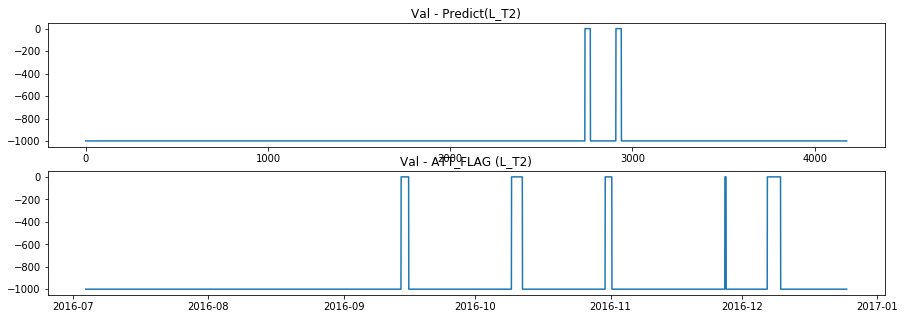

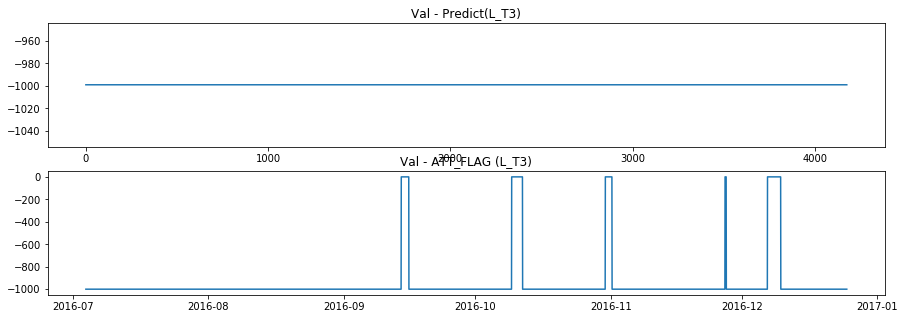

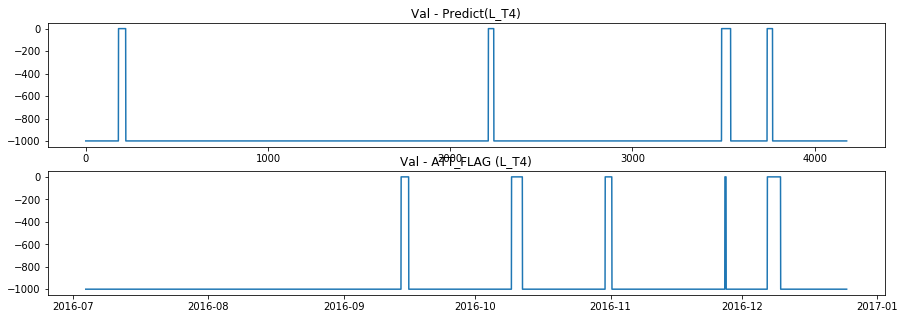

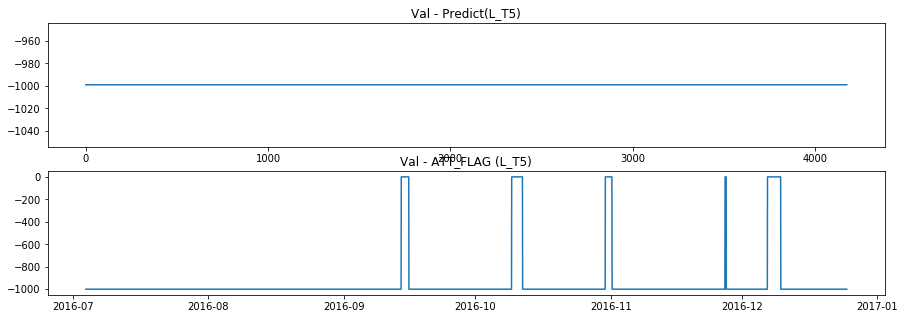

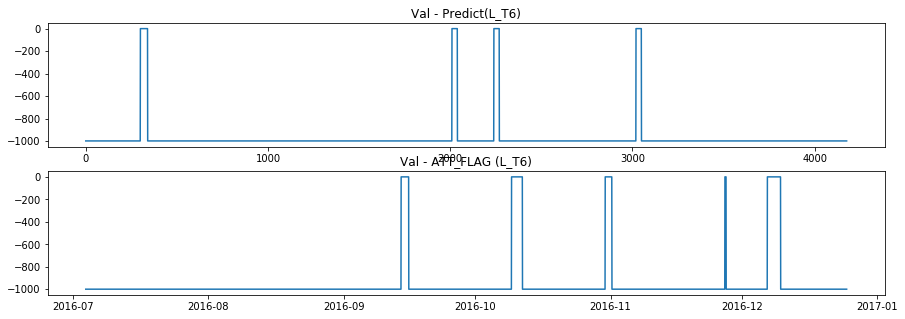

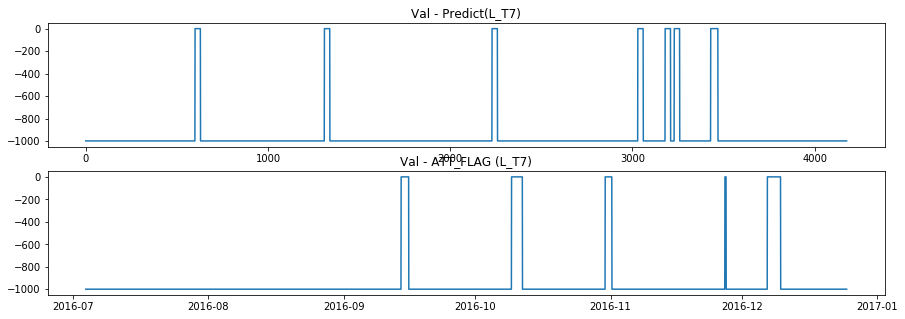

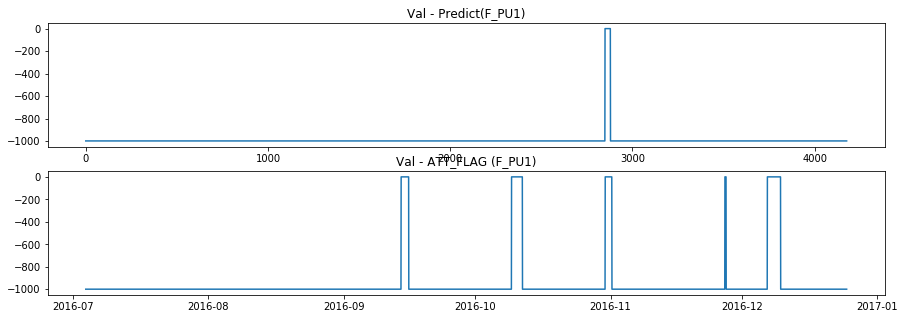

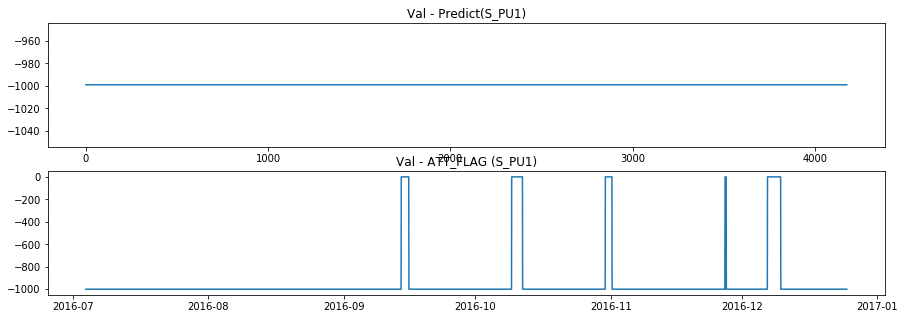

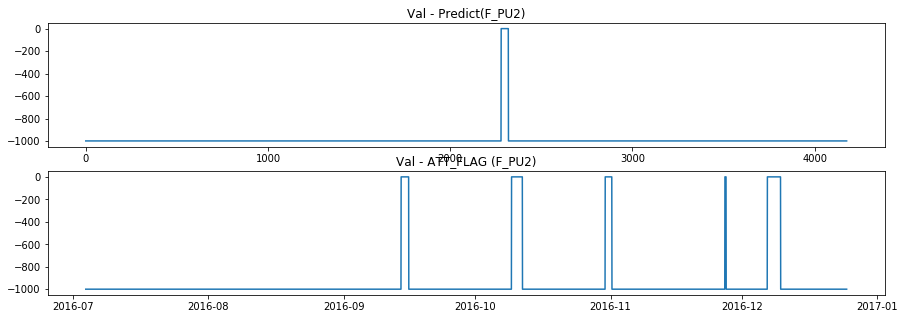

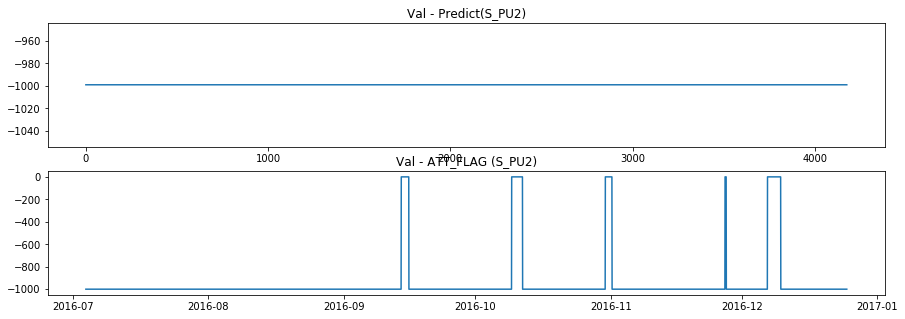

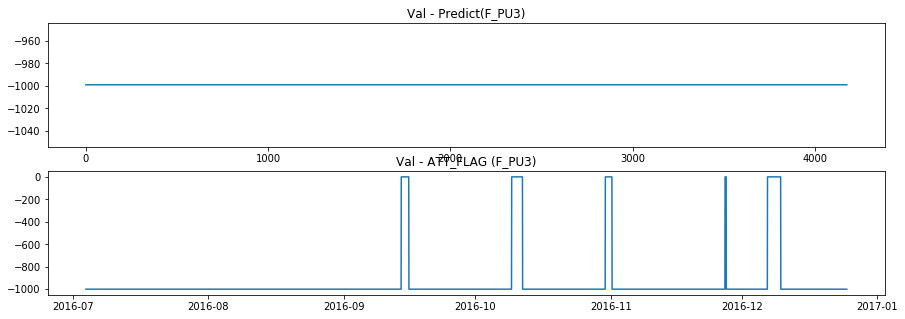

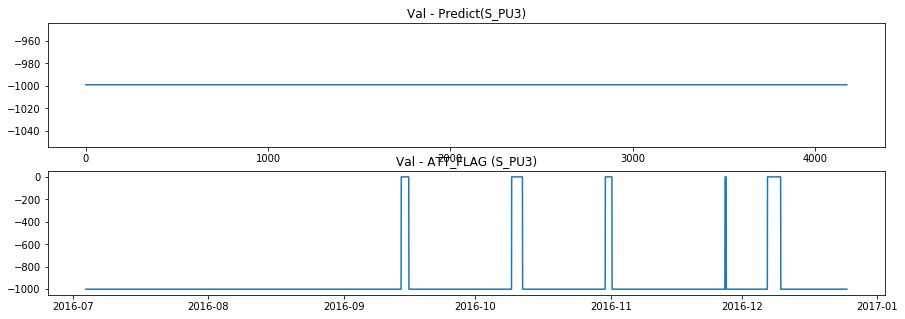

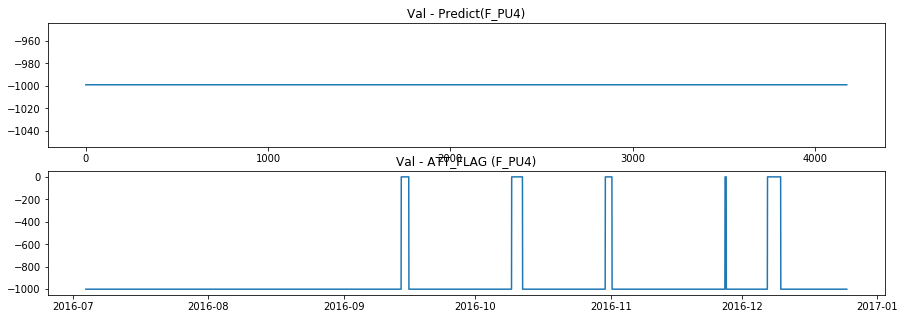

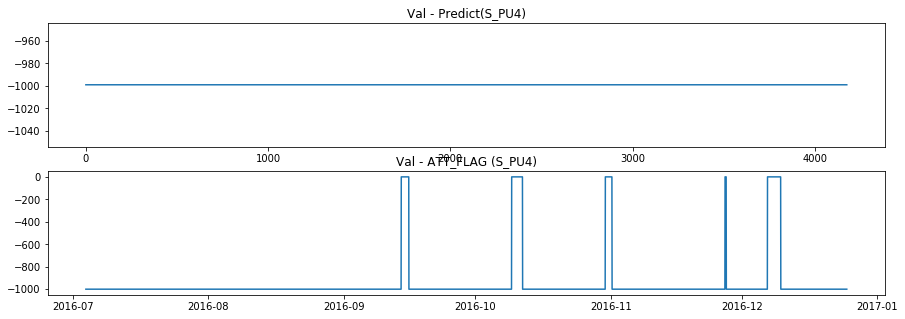

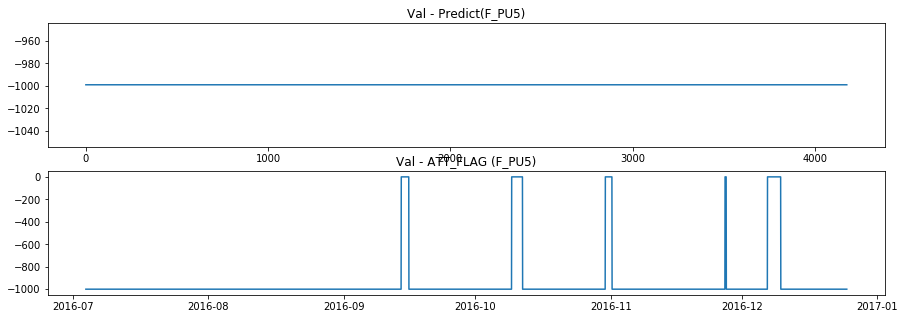

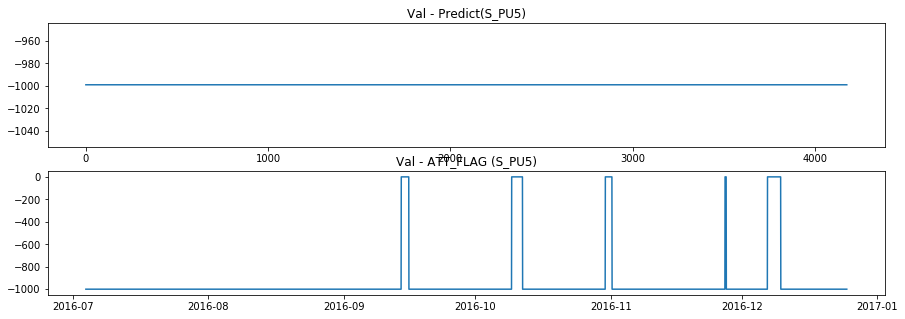

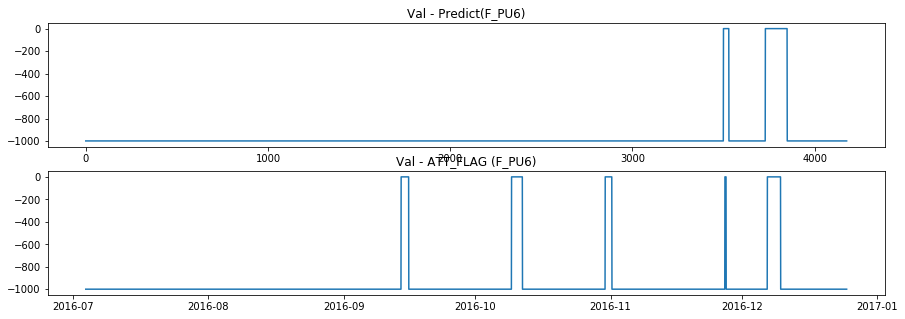

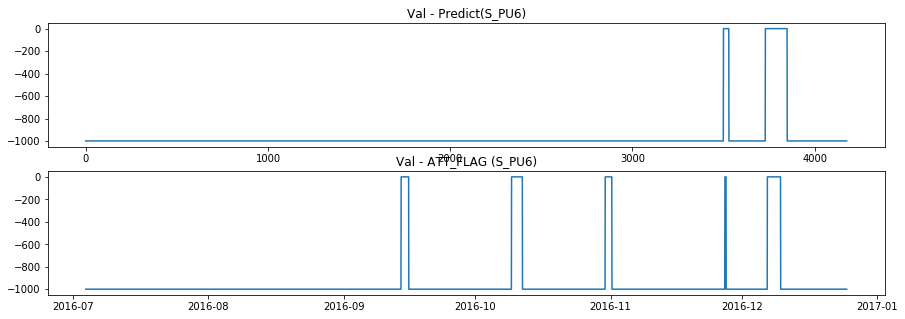

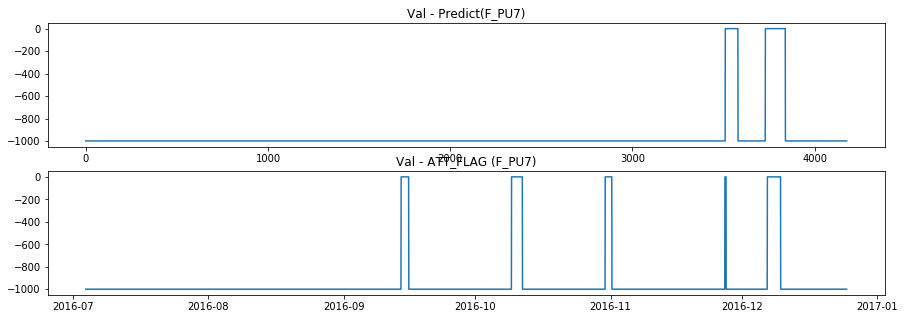

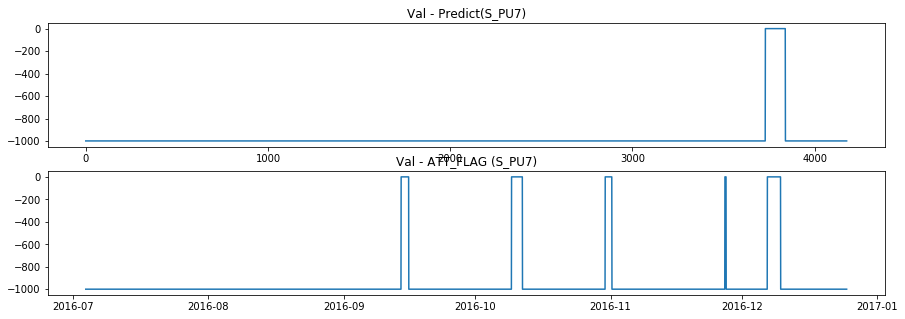

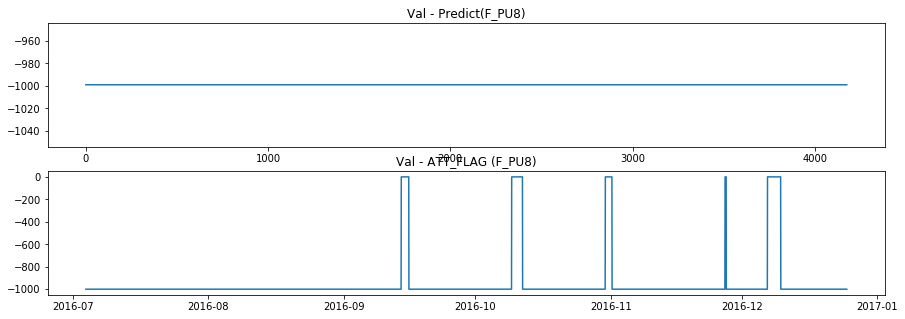

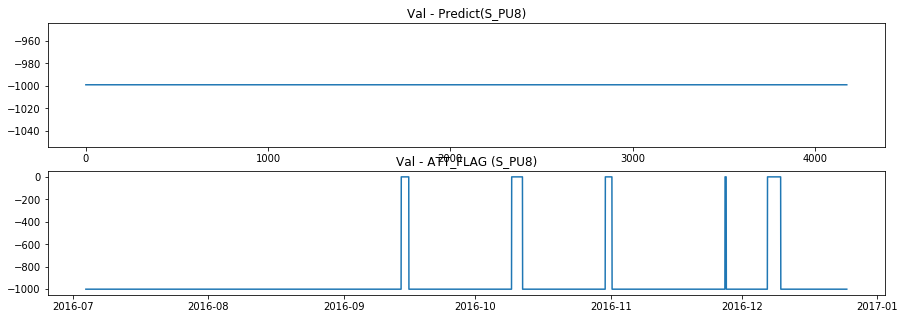

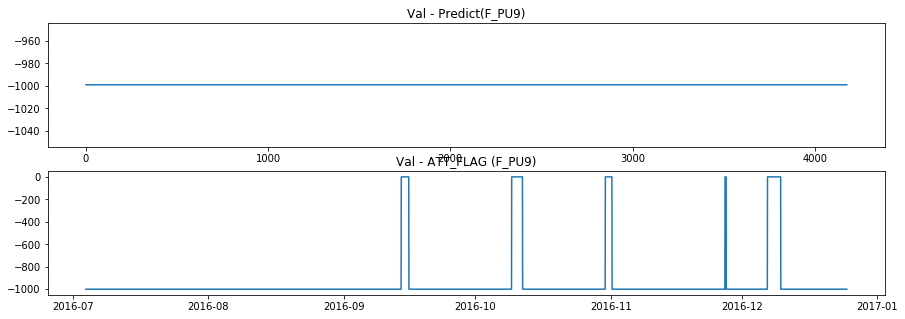

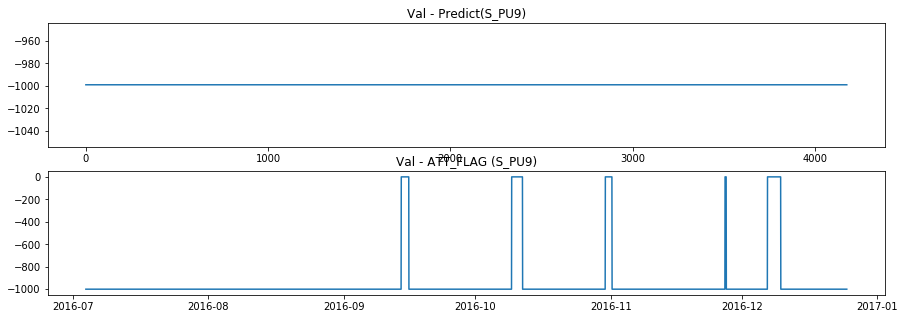

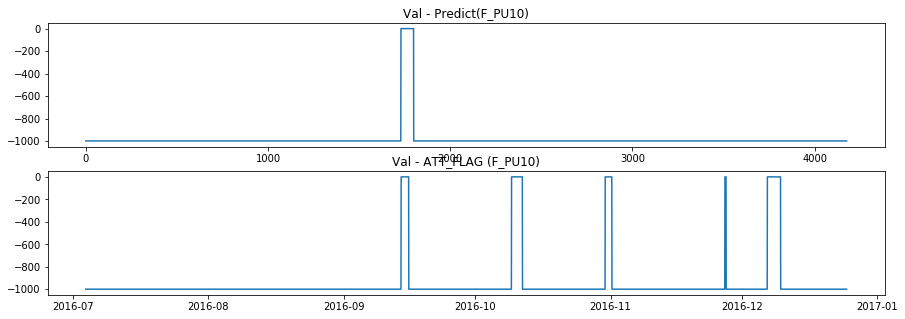

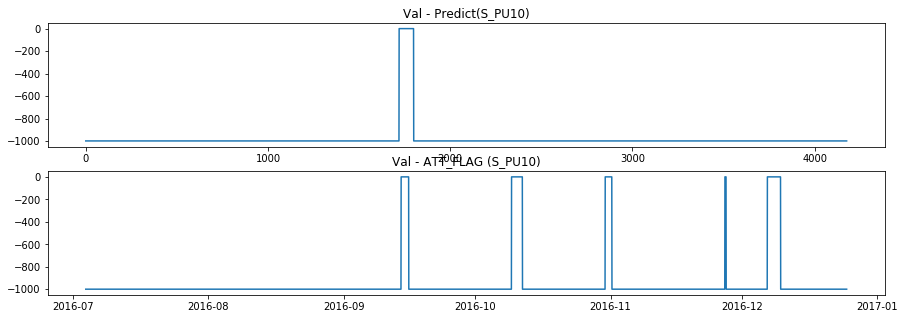

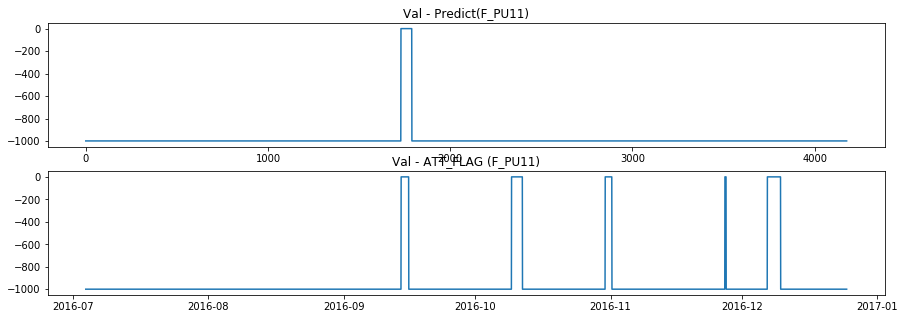

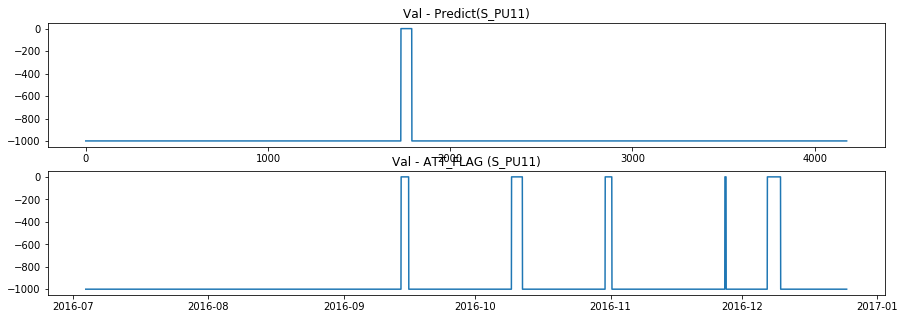

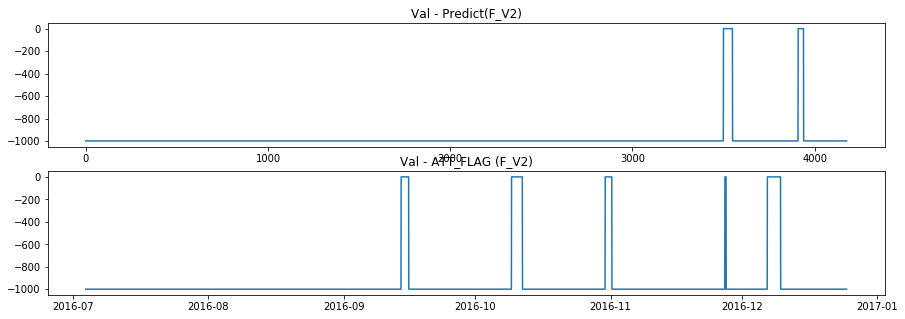

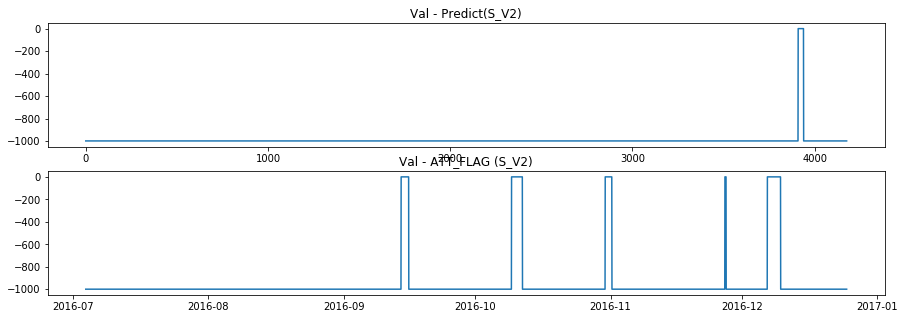

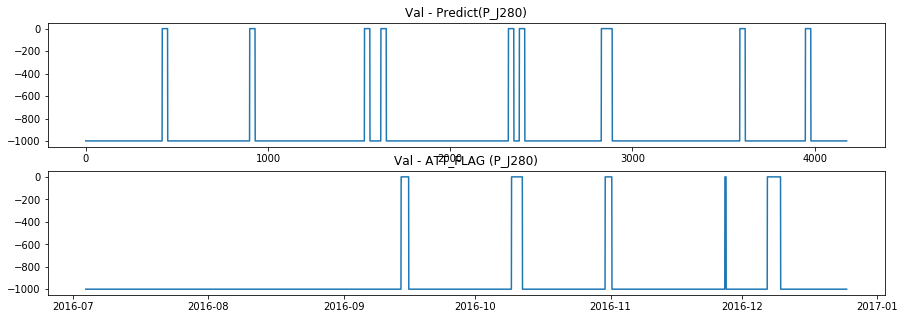

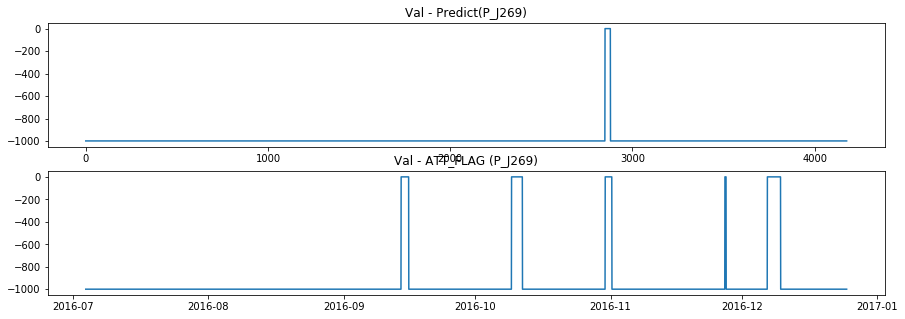

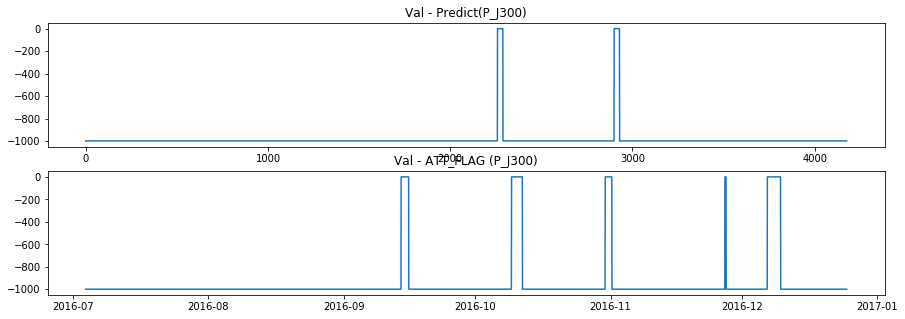

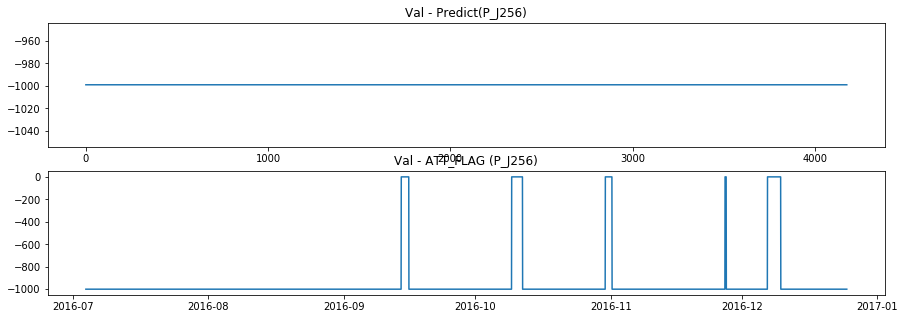

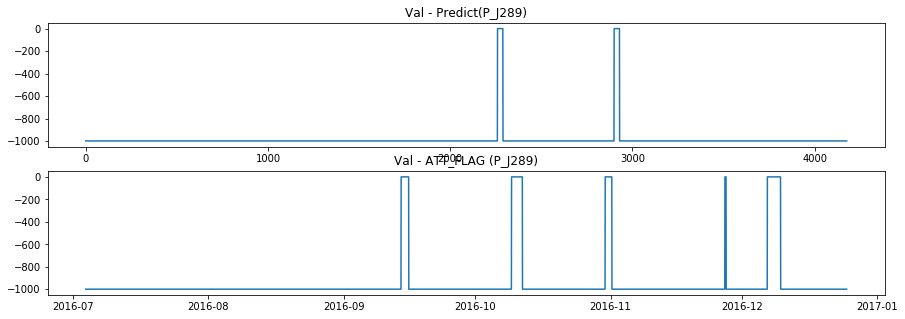

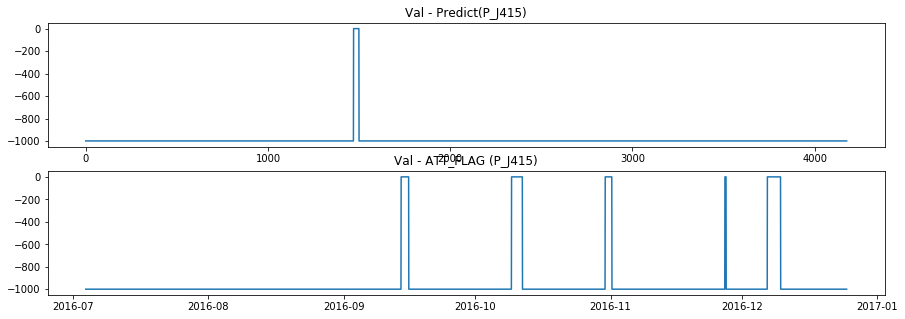

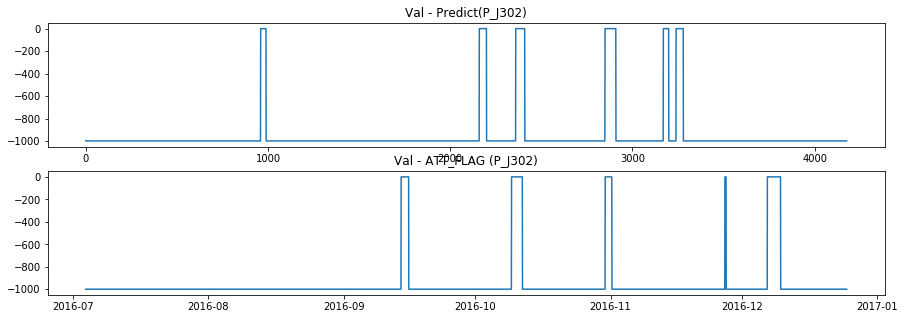

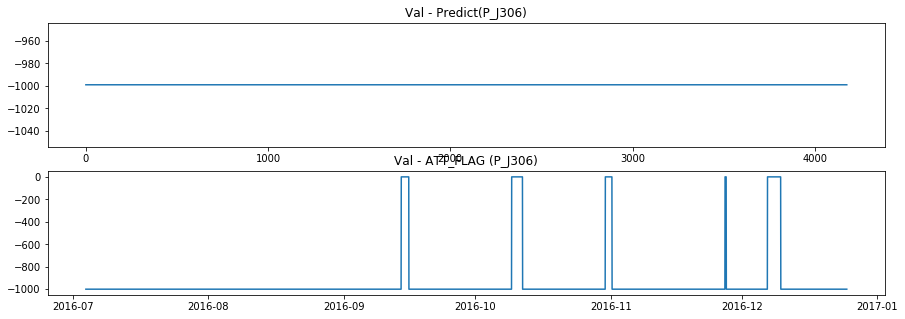

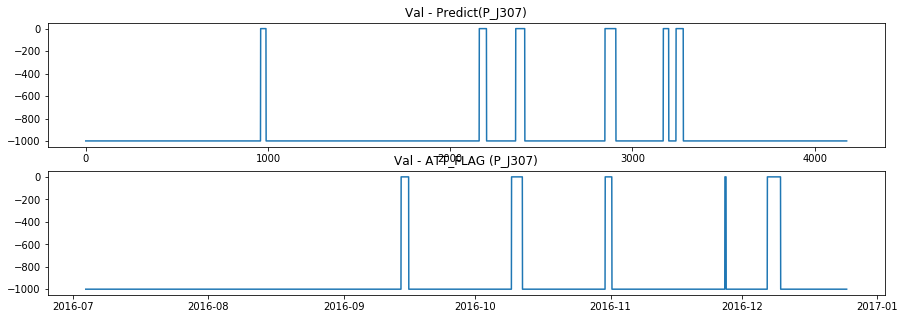

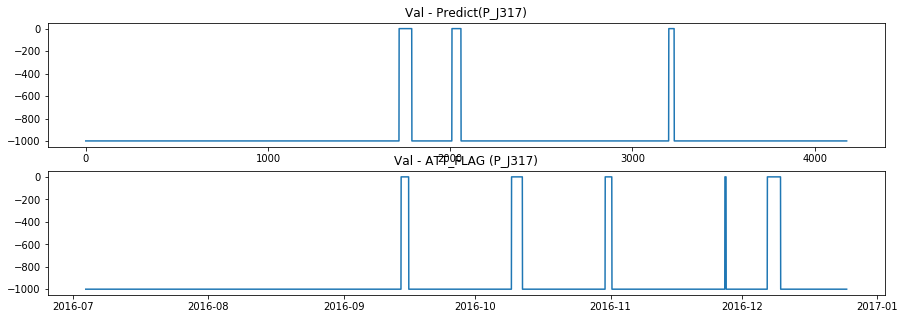

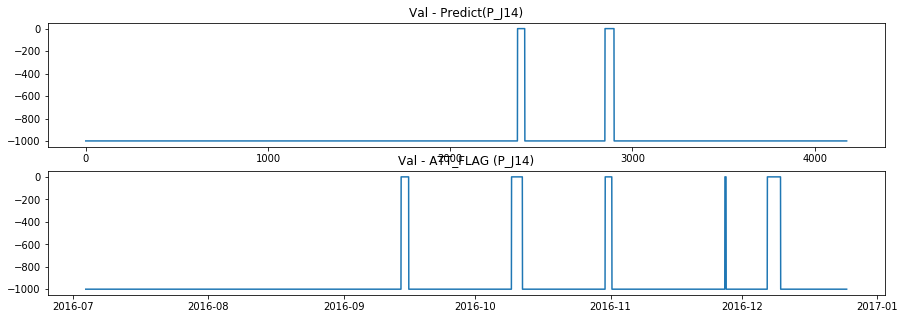

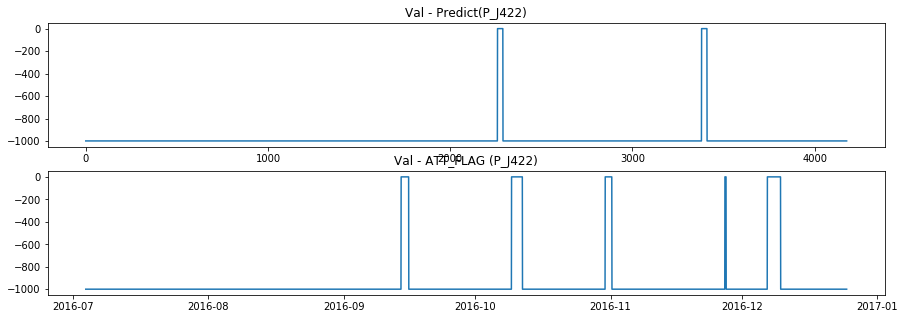

In [4]:
def doDiscretize(df_train, df_val, col, param_PAALen, param_Vocab, data_plot=False, verbose=False):
    result = []
    # Step1 - Get train data values
    if (1):
        data_train                  = df_train[col]
        data_normalized_train       = doNorm(data_train)
        data_paa_train,data_paa_train_idx = doPAA(list(data_normalized_train), param_PAALen)
        data_sax_train              = doStringify(list(data_paa_train), param_Vocab)
        data_sax_train              = ''.join(data_sax_train)
        data_ngrams_train           = doNGrams(data_sax_train)
        data_ngrams_freq_train      = itemfreq(data_ngrams_train)

        # Step2 - Get val data values
        data_val             = df_val[col]
        data_normalized_val  = doNorm(data_val)
        data_paa_val, data_paa_val_idx         = doPAA(list(data_normalized_val), param_PAALen)
        data_sax_val         = doStringify(list(data_paa_val), param_Vocab)
        data_sax_val         = ''.join(data_sax_val)
        data_ngrams_val      = doNGrams(data_sax_val)
        data_ngrams_freq_val = itemfreq(data_ngrams_val) #[('ngram', freq)]
    
    # Step2 - Get anomalies
    if (1):
        anomalies = []
        for ngram_freq in data_ngrams_freq_val:
            if ngram_freq[0] not in data_ngrams_freq_train:
                anomalies.append(ngram_freq[0])
        
        print (' - [DEBUG] For col - ', col, ' || Anomalies : ', anomalies)
        if (0):
            # For col -  P_J280  || Anomalies :  ['acc', 'bbb', 'bbd', 'bca', 'bdb', 'cac', 'cca', 'dbb']
            print (' - [DEBUG] param_PAALen : ', param_PAALen)
            print (' - [DEBUG] data_paa_train : ', len(data_paa_train))
            print (' - [DEBUG] data_paa_val   : ', len(data_paa_val))
            print (' - [DEBUG] data_ngrams_train : ', data_ngrams_train)
            print (' - [DEBUG] data_ngrams_val   : ', data_ngrams_val)
            
    # Step3 - get y_predict
    if (1):
        SIGNAL_LENGTH_SAXVAL = param_PAALen
        SIGNAL_LENGTH_NGRAM  = SIGNAL_LENGTH_SAXVAL*3
        signal_idx           = 0
        Y_true               = df_val['ATT_FLAG'].tolist()
        Y_predict            = np.full(len(df_val), -999)
        if (len(anomalies)):
            for ngram_idx, data_ngram_val in enumerate(data_ngrams_val):
                signal_idx += SIGNAL_LENGTH_SAXVAL
                # print (signal_idx, ' || ', len(df_val))
                if data_ngram_val in anomalies:
                    signal_idx_start = signal_idx
                    signal_idx_end   = signal_idx_start + SIGNAL_LENGTH_NGRAM
                    Y_predict[signal_idx_start:signal_idx_end] = 1
        conf_mat = confusion_matrix(Y_true, Y_predict)
        TN = conf_mat[0][0]
        FP = conf_mat[0][1]
        FN = conf_mat[1][0]
        TP = conf_mat[1][1]
        accuracy = 100.0 * (TP + TN)/(TP + TN + FP + FN)
        if (TP + FP) != 0:
            precision = 100.0 * (TP / (TP + FP))
        else:
             precision = 0
        recall  = 100.0 * (TP / (TP + FN))
        f_score = 100.0 * 2 * (TP /(2*TP + FP + FN))
        # print (' - conf mat : ', conf_mat)
        
        result = [col, TN, FP, FN, TP , accuracy, precision, recall, f_score]
        
    if (verbose):
        print (' - [Params] Total train len : ', len(df_train[col]))
        print (' - [Params] Total val len : ', len(df_val[col]))
        print (' - [Params] Segments : ', param_PAASegs, ' || Bins : ', len(data_paa))
        print (' - [Params] SAX Symbols : ', param_Vocab)
        #print (' - SAX : ', data_sax)
        print (' - data_ngrams_train : ', data_ngrams_train)
        print (' - data_ngrams_freq_train : ', data_ngrams_freq_train)
        print (' - data_ngrams_val : ', data_ngrams_val)
        print (' - data_ngrams_freq_val : ', data_ngrams_freq_val)
    
    if data_plot:
        
        # ATT_FLAG VS PREDICTION
        if (1):
            f,axarr = plt.subplots(2,1, figsize=(15,5))
            axarr[1].plot(df_val['ATT_FLAG'])
            axarr[1].set_title('Val - ATT_FLAG (' + col + ')')
            axarr[0].plot(Y_predict)
            axarr[0].set_title('Val - Predict(' + col + ')')
        
        ################ TRAIN DATA #################
        
        if (0):
            plot_idx = len(df_train)#500
            f,axarr = plt.subplots(2,1, figsize=(15,10))
            axarr[0].plot(data_train[:plot_idx])
            axarr[0].set_title('Train Data - {0}'.format(col))
            axarr[1].plot(data_normalized_train[:plot_idx])
            axarr[1].set_title('Train Normalized Data - {0}'.format(col))
            plt.show()
        
        if (0):
            f,axarr = plt.subplots(2,1, figsize=(15,5))
            axarr[0].plot(data_paa_train)
            axarr[0].set_title('Piece Wise Aggregate Approximation - Segments - {0}'.format(param_PAASegs))
            data_sax_plot = LabelEncoder().fit_transform(list(data_sax_train))
            axarr[1].plot(data_sax_plot)
            axarr[1].set_title('SAX - Vocab - {0}'.format(param_Vocab))
            plt.show()
        
        ################## VAL DATA #################
        
        if (0):
            plot_idx = len(df_val)#500
            f,axarr = plt.subplots(3,1, figsize=(15,5))
            axarr[0].plot(data_val[:plot_idx])
            axarr[0].set_title('Val Data - {0}'.format(col))
            axarr[1].plot(data_normalized_val[:plot_idx])
            axarr[1].set_title('Val Normalized Data - {0}'.format(col))
            axarr[2].plot(df_val['ATT_FLAG'])
            axarr[2].set_title('Val - ATT_FLAG')
            plt.show()
        
        if (0):
            plot_idx = 150 #[len(df_val), 500]
            f,axarr = plt.subplots(3,1, figsize=(15,5))
            axarr[0].plot(data_val[:plot_idx], marker='o')
            # axarr[0].plot(data_normalized_val[:plot_idx], marker='o')
            axarr[0].set_title('(Norm) Val Data - {0}'.format(col))
            
            axarr[1].plot(data_paa_val[:int(plot_idx/param_PAALen)], marker='o')
            axarr[1].set_title('Piece Wise Aggregate Approximation - ({0}) - Segment Len - {1}'.format(col, param_PAALen))
            
            LE = LabelEncoder()
            data_sax_plot = LE.fit_transform(list(data_sax_val))
            axarr[2].plot(data_sax_plot[:int(plot_idx/param_PAALen)], marker='o')
            axarr[2].set_title('SAX - Vocab - {0}'.format(param_Vocab))
            axarr[2].set_yticks(range(len(LE.classes_)))   
            axarr[2].set_yticklabels(LE.classes_)
            
            
            f.tight_layout()
            plt.show()
            
            print (' --------------------------------------------------------------------- ')
    
    return result, Y_predict

if __name__ == "__main__":
    if (1):
        # cols      = ['P_J280', 'P_J415', 'P_J302', 'P_J306', 'P_J307', 'P_J317']
        # cols      = ['P_J415']
        cols         = df_train.columns[:-1]
    else:
        # cols         = ['F_PU6', 'S_PU6', 'F_PU7', 'S_PU7'] # (the last 2 anomalies are detected)
        # cols         = ['F_PU10', 'S_PU10', 'F_PU11', 'S_PU11'] # (the first anomaly is detected)
        # cols         = ['P_J14', 'P_J302', 'P_J307'] # (the 2nd and 3rd anomaly is detected)
        # cols         = ['L_T1']
        cols          = ['F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'P_J14', 'P_J302', 'P_J307']
        
    results      = []
    Y_predicts   = []
    param_Vocab  = 'abcd'
    param_PAALen = 10
    for col in cols:
        result, Y_predict = doDiscretize(df_train, df_val, col
                                         , param_PAALen=param_PAALen, param_Vocab=param_Vocab
                                         , data_plot=True, verbose=False)
        results.append(result)
        Y_predicts.append(Y_predict)
        
    df = pd.DataFrame(results, columns=['column','TN', 'FP','FN', 'TP', 'accuracy', 'precision', 'recall', 'f_score'])
    display(df)
    
    Y_predicts = np.array(Y_predicts).T
    df_predict = pd.DataFrame(Y_predicts, columns=cols)
    df_predict.to_csv('results/03_Discretization_vocab_' + str(param_Vocab) + '_PAA_' + str(param_PAALen) + '.csv', index=False)

# Temp
1. We attempted to use the saxpy library but it was really time consuming since they used np.append